In [74]:
#Importing all the required libraries
import numpy as np
import time
from xclib.data import data_utils
import matplotlib.pyplot as plt

In [75]:
#A fucntion to read the files which is given in sparse format
def read_files(x, y):
    x = '../ass3_parta_data/' + x
    f = open(x, 'r')
    line = f.readline().rstrip("\n").split(" ")
    num_samples, num_feat = int(line[0]), int(line[1])
    data_x = np.zeros((num_samples, num_feat))
    i = 0
    for line in f:
        line = line.split(" ")
        for value in line:
            value = value.split(":")
            data_x[i][int(value[0])] = float(value[1])
        i += 1
    
    data_y = np.genfromtxt('../ass3_parta_data/' + y, delimiter=' ')
    
    return data_x, data_y

s = time.time()
x_train, y_train = read_files('train_x.txt', 'train_y.txt')
x_val, y_val = read_files('valid_x.txt', 'valid_y.txt')
x_test, y_test = read_files('test_x.txt', 'test_y.txt')
print("Data imported in ", time.time()-s, "s")

Data imported in  4.957671403884888 s


In [76]:
#Reading data using librraies

# s = time.time()
# x_train = data_utils.read_sparse_file('../ass3_parta_data/train_x.txt').todense()
# y_train = np.genfromtxt('../ass3_parta_data/train_y.txt', delimiter=' ')

# x_val = data_utils.read_sparse_file('../ass3_parta_data/valid_x.txt').todense()
# y_val = np.genfromtxt('../ass3_parta_data/valid_y.txt', delimiter=' ')

# x_test = data_utils.read_sparse_file('../ass3_parta_data/test_x.txt').todense()
# y_test = np.genfromtxt('../ass3_parta_data/test_y.txt', delimiter=' ')
# print("Data imported in ", time.time()-s, "s")

In [77]:
#SKlearn implementation of decision tree
from sklearn import tree
s = time.time()
clf = tree.DecisionTreeClassifier(criterion='entropy')
m = clf.fit(x_train, y_train)
print("Accuracy over validation set sklearn: ", clf.score(x_val, y_val)*100, "%")
print("Accuracy over test set sklearn: ", clf.score(x_test, y_test)*100, "%")
print("Accuracy over training set sklearn: ", clf.score(x_train, y_train)*100, "%")
print("The depth of the decision tree is: ", clf.get_depth())
print("The number of leaf nodes in the tree is: ", clf.get_n_leaves())
print("Total number of nodes in the tree is: ", clf.tree_.node_count)
print("Time taken:", time.time()-s)

Accuracy over validation set sklearn:  77.21119970331912 %
Accuracy over test set sklearn:  77.83598349636085 %
Accuracy over training set sklearn:  91.27223278166674 %
The depth of the decision tree is:  69
The number of leaf nodes in the tree is:  8025
Total number of nodes in the tree is:  16049
Time taken: 4.507355451583862


In [444]:
#User defined Class for creating node object of decision tree
class Node:
    # Initializer
    def __init__(self, i, t, left, right, label, is_leaf):
        self.index = i
        self.threshold = t
        self.left = left
        self.right = right
        self.label = label
        self.is_leaf = is_leaf
    
    def set_leaf(self):
        self.is_leaf = True
    
    def unset_leaf(self):
        self.is_leaf = False
        
    def to_string(self):
        return str(self.index)+" "+str(self.threshold)+" "+str(self.left)+" "+str(self.right)

#Helper function to get height of a tree with root a    
def get_height(a):   
    if(a==None):
        return -1
    elif(a.is_leaf):
        return 0
    else:
        left_height = get_height(a.left)
        right_height = get_height(a.right)
        return 1 + max(left_height, right_height)

#Helper function to get count of internal(decision) nodes of a tree with root a    
def nodes_count(a):
    if(a==None):
        return 0
    elif(a.is_leaf):
        return 0
    else:
        return 1 + nodes_count(a.left) + nodes_count(a.right)

#Helper function to get count of all internal(decision) and external(leaves) nodes of a tree with root a    
def node_leaves_count(a):
    if(a==None):
        return 0
    elif(a.is_leaf):
        return 1
    else:
        return 1 + node_leaves_count(a.left) + node_leaves_count(a.right)

In [167]:
#Helper function to get entropy of a variable with just two labels having their counts as parameters
def entropy(count_0, count_1):
    
    h_y = None
    
    if(count_0==0 or count_1==0):
        h_y = 0
    else:
        p_0 = count_0/(count_0 + count_1)
        p_1 = count_1/(count_0 + count_1)
        h_y = -(p_0*np.log2(p_0) + p_1*np.log2(p_1))
        
    return h_y

#To select the best attribute of a given dataset
#Returns the best attribute's index and the median value associated with it
def best_attribute(dataset, y, count_0, count_1):
    
    h_y = entropy(count_0, count_1)
    
    #Median value of attributes
    medians = np.median(dataset, axis = 0)
    non_zeros = np.count_nonzero(dataset, axis=0)
    
    best_index = -1
    best_ig = -float('inf')
    best_median = None
    
    total = count_0 + count_1
    
    #Iterating for each attribute
    for index, median in enumerate(medians):
        
        if(non_zeros[index] == 0):
            if(0>best_ig):
                best_index = index
                best_ig = 0
                best_median = median 
        
        index_neg = np.argwhere(dataset[:,index] <= median).flatten()
        index_pos = np.argwhere(dataset[:,index] > median).flatten()
        count_neg = index_neg.shape[0]
        count_pos = index_pos.shape[0]
        
        #if all the data belong to just one label, then information gain is 0 in that case
        if(count_neg==total or count_pos==total):
            if(0>best_ig):
                best_index = index
                best_ig = 0
                best_median = median
        else:
            
            y_neg = y[index_neg]
            y_pos = y[index_pos]
            
            count_1_neg = np.count_nonzero(y_neg)
            entropy_neg = (count_neg/total) * entropy(count_neg - count_1_neg, count_1_neg)
            
            count_1_pos = np.count_nonzero(y_pos)
            entropy_pos = (count_pos/total) * entropy(count_pos - count_1_pos, count_1_pos)
            
            ig = h_y - entropy_neg - entropy_pos
            
            #Selecting best attribute based on information gain
            if(ig>best_ig):
                best_index = index
                best_ig = ig
                best_median = median
        
    return best_index, best_median

In [168]:
#Recursive function to grow the tree using ID3 algorithm
def grow_tree(dataset, y):
    
    count = y.shape[0]
    
    if(count==0):
        return None
    
    index_0 = np.argwhere(y==0)
    index_1 = np.argwhere(y==1)
    
    #Stopping criteria for growing tree, if all the data belong to just one label
    if(index_1.shape[0] == count):
        return Node(None, None, None, None, 1, True)
    elif(index_0.shape[0] == count):
        return Node(None, None, None, None, 0, True)
    else:
        
        label = -1
        if(index_1.shape[0] > index_0.shape[0]):
            label = 1
        else:
            label = 0
            
        index, threshold = best_attribute(dataset, y, index_0.shape[0], index_1.shape[0])
        
        index_neg = np.argwhere(dataset[:,index] <= threshold).flatten()
        index_pos = np.argwhere(dataset[:,index] > threshold).flatten()
        
        data_0, y_0 = dataset[index_neg][:], y[index_neg]
        data_1, y_1 = dataset[index_pos][:], y[index_pos]
        
        #Stopping criteria for growing tree
        #if all the data after splitting on best attribute belong to just one label
        if(y_1.shape[0] == 0 or y_0.shape[0] == 0):
            return Node(index, threshold, None, None, label, True)
        
        return Node(index, threshold, grow_tree(data_0, y_0), grow_tree(data_1, y_1), label, False)

In [169]:
#Growing a tree
s = time.time()
m = grow_tree(x_train, y_train)
print("Time taken is:",time.time()-s)

Time taken is: 126.86101484298706


In [287]:
#Predicting label for a given row of data
def pred_row(root, row):
    n = root
    while(n!=None):
        if(n.is_leaf):
            return n.label
        else:
            i = n.index
            t = n.threshold
            if(row[i] <= t):
                n = n.left
            else:
                n = n.right
    return -1

#Calculating accuracy for a dataset for given decision tree
def accuracy(root, x, y):
    res = np.vectorize(lambda i: pred_row(root, x[i]))(np.arange(y.shape[0]))
    err = abs(y - res).sum()
    return 1 - err/y.shape[0]

In [171]:
#Getting all the informations about the learned decision tree
s = time.time()
print("Accuracy over training set is: ", accuracy(m, x_train, y_train)*100,"%")
print("Accuracy over Validation set is: ", accuracy(m, x_val, y_val)*100,"%")
print("Accuracy over Test set is: ", accuracy(m, x_test, y_test)*100,"%")
print("Time taken to predict: ", time.time()-s)
print("Height of the fully grown tree is:", get_height(m))
#Internal(decision) nodes
print("Total number of nodes excluding leaves in fully grown tree is:", node_count(m))
#Internal(decision) plus external(leaf) nodes
print("Total number of nodes including leaves in fully grown tree is:", node_leaves_count(m))

Accuracy over training set is:  90.45786781635839 %
Accuracy over Validation set is:  77.63767847209346 %
Accuracy over Test set is:  77.99823837559686 %
Time taken to predict:  1.1096446514129639
Height of the fully grown tree is: 52
Total number of nodes excluding leaves in fully grown tree is: 10005
Total number of nodes including leaves in fully grown tree is: 20011


In [172]:
#A function that gets Validation, Test and Train accuracy while learning the tree
#As the nodes are added in the tree, this function is called to get the accuracy
def get_points():
    
    global n_nodes
    
    val_plot.append( accuracy(root, x_val, y_val))
    test_plot.append( accuracy(root, x_test, y_test))
    train_plot.append( accuracy(root, x_train, y_train))
    x_axis.append(n_nodes+1)
    
    print(n_nodes)

In [173]:
#A different version of recursive algorithm to learn decision tree using ID3 algorithm
#This is done so that accuracy can also be calculated for datasets as we learn the tree
#Accuracy is calculated for every 10 nodes added in the tree

def grow_tree_v2(node, dataset, y):
    
    global n_nodes 
    
    count = y.shape[0]
    
    if(count==0):
        node = None
        return
    
    index_0 = np.argwhere(y==0)
    index_1 = np.argwhere(y==1)
    
    #Stopping criteria for growing tree, if all the data belong to just one label
    if(index_1.shape[0] == count):
        node.label = 1
        node.is_leaf = True
        
        if(n_nodes%10 == 0):
            get_points()
        n_nodes += 1
        
        return
    
    #Stopping criteria for growing tree, if all the data belong to just one label  
    elif(index_0.shape[0] == count):
        node.label = 0
        node.is_leaf = True
        
        if(n_nodes%10 == 0):
            get_points()
        n_nodes += 1
        
        return
        
    else:
        
        label = -1
        if(index_1.shape[0] >= index_0.shape[0]):
            label = 1
        else:
            label = 0
        
        node.label = label
        node.is_leaf = True
        
        #For every 10 nodes, the function is called to get the accuracy for different datasets
        if(n_nodes%10 == 0):
            get_points()
        n_nodes += 1
        
        node.is_leaf = False
        
        index, threshold = best_attribute(dataset, y, index_0.shape[0], index_1.shape[0])
        
        index_neg = np.argwhere(dataset[:,index] <= threshold).flatten()
        index_pos = np.argwhere(dataset[:,index] > threshold).flatten()
        
        data_0, y_0 = dataset[index_neg][:], y[index_neg]
        data_1, y_1 = dataset[index_pos][:], y[index_pos]
        
        node.index = index
        node.threshold = threshold
        
        #Stopping criteria for growing tree
        #if all the data after splitting on best attribute belong to just one label
        if(y_1.shape[0] == 0 or y_0.shape[0] == 0):
            node.is_leaf = True
            return
        
        label_r = np.count_nonzero(y_1)
        if((y_1.shape[0]-label_r) > label_r):
            label_r = 0
        else:
            label_r = 1
            
        node.left = Node(None, None, None, None, -1, False)
        node.right = Node(None, None, None, None, label_r, True)
        grow_tree_v2(node.left, data_0, y_0)
        
        node.right = Node(None, None, None, None, -1, False)
        grow_tree_v2(node.right, data_1, y_1)
        
        return

In [174]:
#Root is made global
root = Node(None, None, None, None, -1, False)
#Different lists for storing accuracy and node counts as the tree grows
val_plot = []
train_plot = []
test_plot = []
x_axis = []
n_nodes = 0

#Learning the tree using the second version of grow_tree function
s=time.time()
grow_tree_v2(root, x_train, y_train)
print("Time taken: ", time.time()-s)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

15510
15520
15530
15540
15550
15560
15570
15580
15590
15600
15610
15620
15630
15640
15650
15660
15670
15680
15690
15700
15710
15720
15730
15740
15750
15760
15770
15780
15790
15800
15810
15820
15830
15840
15850
15860
15870
15880
15890
15900
15910
15920
15930
15940
15950
15960
15970
15980
15990
16000
16010
16020
16030
16040
16050
16060
16070
16080
16090
16100
16110
16120
16130
16140
16150
16160
16170
16180
16190
16200
16210
16220
16230
16240
16250
16260
16270
16280
16290
16300
16310
16320
16330
16340
16350
16360
16370
16380
16390
16400
16410
16420
16430
16440
16450
16460
16470
16480
16490
16500
16510
16520
16530
16540
16550
16560
16570
16580
16590
16600
16610
16620
16630
16640
16650
16660
16670
16680
16690
16700
16710
16720
16730
16740
16750
16760
16770
16780
16790
16800
16810
16820
16830
16840
16850
16860
16870
16880
16890
16900
16910
16920
16930
16940
16950
16960
16970
16980
16990
17000
17010
17020
17030
17040
17050
17060
17070
17080
17090
17100
17110
17120
17130
17140
17150
17160
1717

In [176]:
#Getting all the informations about the learned decision tree
#It comes out to be same as the previous version
s = time.time()
print("Accuracy over training set is: ", accuracy(root, x_train, y_train)*100,"%")
print("Accuracy over Validation set is: ", accuracy(root, x_val, y_val)*100,"%")
print("Accuracy over Test set is: ", accuracy(root, x_test, y_test)*100,"%")
print("Height of the fully grown tree is:", get_height(root))
print("Total number of nodes excluding leaves in fully grown tree is:", node_count(root))
print("Total number of nodes including leaves in fully grown tree is:", node_leaves_count(root))

Accuracy over training set is:  90.45786781635839 %
Accuracy over Validation set is:  77.32709067309476 %
Accuracy over Test set is:  77.79426081312873 %
Height of the fully grown tree is: 52
Total number of nodes excluding leaves in fully grown tree is: 10005
Total number of nodes including leaves in fully grown tree is: 20011


In [179]:
#Saving the info in file for future reference so that time is saved
np.savetxt('plots.txt', (x_axis, val_plot, test_plot, train_plot), delimiter=' ')

In [441]:
#Loading the saved info about accuracy as decision tree grows
#This part is invoked only if required
p = np.loadtxt('plots.txt')
x_axis = p[0]
val_plot = p[1]
test_plot = p[2]
train_plot = p[3]

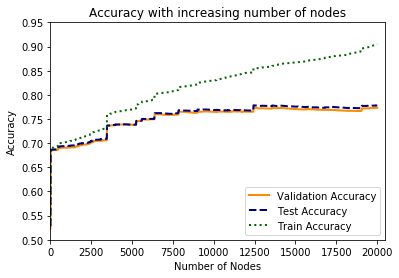

In [443]:
#Plotting the required results
plt.figure()
lw=2
plt.plot(x_axis, val_plot, color='darkorange', lw=lw, label='Validation Accuracy')
plt.plot(x_axis, test_plot, color='navy', lw=lw, linestyle='--', label='Test Accuracy')
plt.plot(x_axis, train_plot, color='darkgreen', lw=lw, linestyle='dotted', label='Train Accuracy')
plt.xlim([0, 20500])
plt.ylim([0.5, 0.95])
plt.ylabel('Accuracy')
plt.xlabel('Number of Nodes')
plt.title('Accuracy with increasing number of nodes')
plt.legend(loc="lower right")
plt.show()

In [367]:
#Function to get BFS list of a tree with given root, only the internal(decision) nodes are counted
def bfs_nodes(root):
    
    check = [root]
    bfs = []
    
    while(len(check) > 0):
        
        n = check.pop(0)
        
        if(n.is_leaf or n==None):
            continue        
        
        check.append(n.left)
        check.append(n.right)
        bfs.append(n)
        
    return bfs

In [376]:
#Function to get BFS list of a tree with given root, all internal(decision) as well as external nodes are counted
def bfs_all(root):
    
    check = [root]
    bfs = []
    
    while(len(check) > 0):
        
        n = check.pop(0)
        bfs.append(n)
        
        if(n.is_leaf or n==None):
            continue        
        
        check.append(n.left)
        check.append(n.right)

    return bfs

In [409]:
#Function to get BFS list of a tree with given root, only the external(leaf) nodes are counted
def bfs_leaf(root):
    
    check = [root]
    bfs = []
    
    while(len(check) > 0):
        
        n = check.pop(0)
        
        if(n.is_leaf or n==None):
            bfs.append(n)
            continue        
        
        check.append(n.left)
        check.append(n.right)
        
    return bfs

In [ ]:
#Growing the tree with 1st version, takes less time, accuracy is not required.
s = time.time()
root = grow_tree(x_train, y_train)
print("Time taken is:",time.time()-s)

In [ ]:
l = bfs(root)

In [ ]:
for i in l:
    i.is_leaf = False

In [410]:
node_leaves_count(root), get_height(root)

10006

In [379]:
#As the validation data is predicted, this part of code stores the count of each label 
#for the subset of dataset that reaches each node.
#Helps in calculating number of validation datasets that are being misclassified at each node

d = []
d.append({})
d.append({})

for i in range(len(x_val)):
    x = x_val[i]
    y = int(y_val[i])
    
    n = root
    while(n!=None):
        
        if(n in d[y]):
            d[y][n] = d[y].get(n) + 1
        else:
            d[y][n] = 1
            
            
        if(n.is_leaf):
            break
        else:
            i = n.index
            t = n.threshold
            if(x[i] <= t):
                n = n.left
            else:
                n = n.right
    

In [380]:
#A dictionary that stores number of validation data set that are misclassified 
#at each node if that node was a leaf
mis = {}
all_nodes = bfs_all(root)

In [381]:
#For each node in tree store the misclassified datas at each node

#This is done so that when we are pruning the tree we don't have to call accuracy function(saves time)
for n in all_nodes:
    label = n.label
    
    if(n not in d[1-label] and n not in d[label]):
        mis[n] = None
    
    if(n in d[1-label]):
        mis[n] = d[1-label][n]
    else:
        mis[n] = 0

In [411]:
#A function to post prune the tree based on pruning node that increased maximum accuracy

#We can directly get the number of misclassifications of validation dataset if that node was a leaf, as
#compared to number of misclassification if that whole subtree(with that node as root) was being used
#If the node gives less misclassification than the subtree, then it's better to prune the node.
#We can get the node that gives maximum decrease in number of misclassification and prune that one

#It saves al lot of time and speeds up pruning process by an enormous factor.

def prune(l, e):
    
    prune_node = None
    curr_e = 0
    
    while(len(bfs_list) > 0):
        
        node = bfs_list.pop()
        
        #Misclassification if that node was a leaf
        p_err = e[node]
        c_err = 0
        
        #All the leaves of that subtree
        child = bfs_leaf(node)
        
        #Sum of misclassification by that entire subtree
        for c in child:
            c_err += e[c]
        
        #Getting the node with maximum decrease in misclassifications after pruning
        if((c_err - p_err) > curr_e):
            curr_e = c_err - p_err
            prune_node = node
    
    if(prune_node == None):
        return False
    else:
        prune_node.is_leaf = True
        return True

In [ ]:
# def max_prune(bfs_list):
    
#     curr_acc = accuracy_new(root, x_val, y_val)
#     prune_node = None
    
#     while(len(bfs_list) > 0):
        
#         node = bfs_list.pop()
        
#         node.is_leaf = True
#         acc = accuracy_new(root, x_val, y_val)
        
#         if(acc > curr_acc):
#             curr_acc = acc
#             prune_node = node
        
#         node.is_leaf = False
    
#     if(prune_node == None):
#         return False
#     else:
#         prune_node.is_leaf = True
#         return True

In [412]:
# Part of the code that prunes the tree as long as there is no increase in accuracy over validation set

s = time.time()

acc_val = [accuracy(root, x_val, y_val)]
acc_test = [accuracy(root, x_test, y_test)]
acc_train = [accuracy(root, x_train, y_train)]
node_count = [node_leaves_count(root)]

print(acc_val, acc_test, acc_train, node_count)

prune_count = 0

while(True):
    
    s1 = time.time()
    print("Going for prune_count: ", prune_count+1)
    
    #Getting all the internal(decision) nodes to be considered for pruning
    bfs_list = bfs_nodes(root)
    
    #Getting result if pruning is possible or not
    res = prune(bfs_list, mis)
    
    print("Done for prune_count: ", prune_count+1, "in time:", time.time()-s1)
    
    if(res):
        
        acc_val.append(accuracy(root, x_val, y_val))
        acc_test.append(accuracy(root, x_test, y_test))
        acc_train.append(accuracy(root, x_train, y_train))
        
        count = node_leaves_count(root)
        node_count.append(count)
        
        prune_count += 1
        print("Node Count: ", count)
        
        continue
        
    break
    
print("Pruning done, time taken : ", time.time()-s)

[0.7763767847209345] [0.7799823837559686] [0.9045786781635838] [20011]
Going for prune_count:  1
Done for prune_count:  1 in time: 0.28839564323425293
Node Count:  13383
Going for prune_count:  2
Done for prune_count:  2 in time: 0.1679990291595459
Node Count:  12177
Going for prune_count:  3
Done for prune_count:  3 in time: 0.1394495964050293
Node Count:  11537
Going for prune_count:  4
Done for prune_count:  4 in time: 0.1306931972503662
Node Count:  11073
Going for prune_count:  5
Done for prune_count:  5 in time: 0.17090487480163574
Node Count:  10633
Going for prune_count:  6
Done for prune_count:  6 in time: 0.12625694274902344
Node Count:  10087
Going for prune_count:  7
Done for prune_count:  7 in time: 0.15182280540466309
Node Count:  9993
Going for prune_count:  8
Done for prune_count:  8 in time: 0.10413241386413574
Node Count:  9939
Going for prune_count:  9
Done for prune_count:  9 in time: 0.1431410312652588
Node Count:  9783
Going for prune_count:  10
Done for prune_cou

Node Count:  6087
Going for prune_count:  83
Done for prune_count:  83 in time: 0.06642365455627441
Node Count:  6065
Going for prune_count:  84
Done for prune_count:  84 in time: 0.06973004341125488
Node Count:  6051
Going for prune_count:  85
Done for prune_count:  85 in time: 0.06331634521484375
Node Count:  6035
Going for prune_count:  86
Done for prune_count:  86 in time: 0.05877232551574707
Node Count:  6033
Going for prune_count:  87
Done for prune_count:  87 in time: 0.06377601623535156
Node Count:  6021
Going for prune_count:  88
Done for prune_count:  88 in time: 0.061557769775390625
Node Count:  6019
Going for prune_count:  89
Done for prune_count:  89 in time: 0.05890297889709473
Node Count:  6005
Going for prune_count:  90
Done for prune_count:  90 in time: 0.0604860782623291
Node Count:  5991
Going for prune_count:  91
Done for prune_count:  91 in time: 0.06292581558227539
Node Count:  5985
Going for prune_count:  92
Done for prune_count:  92 in time: 0.05918717384338379


Node Count:  5433
Going for prune_count:  164
Done for prune_count:  164 in time: 0.054045915603637695
Node Count:  5421
Going for prune_count:  165
Done for prune_count:  165 in time: 0.05443310737609863
Node Count:  5419
Going for prune_count:  166
Done for prune_count:  166 in time: 0.051207780838012695
Node Count:  5401
Going for prune_count:  167
Done for prune_count:  167 in time: 0.062136173248291016
Node Count:  5397
Going for prune_count:  168
Done for prune_count:  168 in time: 0.052561283111572266
Node Count:  5395
Going for prune_count:  169
Done for prune_count:  169 in time: 0.0563349723815918
Node Count:  5389
Going for prune_count:  170
Done for prune_count:  170 in time: 0.053797006607055664
Node Count:  5385
Going for prune_count:  171
Done for prune_count:  171 in time: 0.05641317367553711
Node Count:  5381
Going for prune_count:  172
Done for prune_count:  172 in time: 0.05334949493408203
Node Count:  5365
Going for prune_count:  173
Done for prune_count:  173 in ti

In [413]:
#Number of external(leaf) + internal(decision) nodes in pruned tree
# number of internal(decision) nodes in pruned tree
node_leaves_count(root), get_height(root)

(5159, 47)

In [428]:
#Saving info for future reference so that don't have to do gain
np.savetxt('prune.txt', (node_count, acc_val, acc_test, acc_train), delimiter=' ')

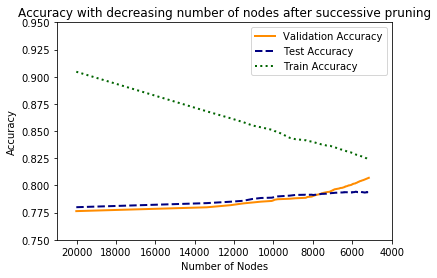

In [432]:
#Plotting the desired result
plt.figure()
lw=2
plt.plot(node_count, acc_val, color='darkorange', lw=lw, label='Validation Accuracy')
plt.plot(node_count, acc_test, color='navy', lw=lw, linestyle='--', label='Test Accuracy')
plt.plot(node_count, acc_train, color='darkgreen', lw=lw, linestyle='dotted', label='Train Accuracy')
plt.xlim([21000, 4000])
plt.ylim([0.75, 0.95])
plt.ylabel('Accuracy')
plt.xlabel('Number of Nodes')
plt.title('Accuracy with decreasing number of nodes after successive pruning')
plt.legend(loc="upper right")
plt.show()

In [423]:
#Getting accuracy after pruning is done
accuracy(root, x_val, y_val), accuracy(root,x_test,y_test), accuracy(root, x_train, y_train)

(0.8070183571296125, 0.7940753789810393, 0.8237757483040502)

In [426]:
#Getting count of decision nodes in pruned tree
nodes_count(root)

2579

In [435]:
s = time.time()
m = grow_tree(x_train, y_train)
print("Time taken is:",time.time()-s)

Time taken is: 121.23822379112244


In [436]:
#getting count of total nodes in left and right subtree of root
node_leaves_count(m.left), node_leaves_count(m.right)

(12419, 7591)